# Find Stars with Photutils &#x1F31F; &#x2728;
just kidding this is clickbait

Index: 
1. Photutils
2. Radial Profile + FWHM 
2. A little about the algorithm in play
3. Let's hunt some stars
4. While we are at it, let's do aperture photometry as well
5.  Use cases of DaoStarFinder

## Photutils 

Photutils is a python package coordinated by the Astropy Project for commonly used tools for detecting and performing photometry of astronomical sources. 

Some tools that we will be using today: 

- `Background Estimation`
- `Finding Stars`
- `Aperture Photometry`
- `Datasets and Simulations`

## A little about the algorithm in play

1. Estimating FWHM (`RadialProfile` or `fit_fwhm`)
2. Background Subtraction
3. Point Source Detection (Finding stars)
4. Aperture Photometry
5. Let's get the photometry of real astronomical data
6. Misc (Morphology, Datasets and simulation)
7. Use case of DaoStarFinder

In [ ]:
def find_stars(data, fwhm, std_multiple=5., sigma=3.0):
    mean, median, std = sigma_clipped_stats(data, sigma=sigma)
    daofind = DAOStarFinder(fwhm=3.0, threshold=std_multiple*std)
    sources = daofind(data - median)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    print(f"Number of stars found: {len(positions)}")
    apertures = CircularAperture(positions, r=4)
    # norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(data,
               cmap='Greys',
               origin='lower',
            #    norm=norm,
               interpolation='nearest')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
## Radial Profile

# Finding FWHM

## using `RadialProfile`

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.models import Gaussian2D              # to create a 2D gaussian
from astropy.visualization import simple_norm               # for image normalization

from photutils.centroids import centroid_quadratic          # to get the positions of the gaussian
from photutils.datasets import make_noise_image            
from photutils.profiles import RadialProfile

In [100]:
# create an artificial single source
gmodel = Gaussian2D(42.1, 47.8, 52.4, 4.7, 4.7, 0)
yy, xx = np.mgrid[0:100, 0:100]
data = gmodel(xx, yy)
bkg_sig = 2.4
noise = make_noise_image(data.shape, mean=0., stddev=bkg_sig, seed=123)
data += noise
error = np.zeros_like(data) + bkg_sig

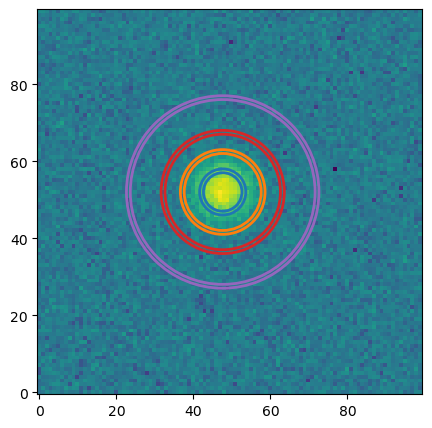

In [ ]:
# find the source centroid
xycen = centroid_quadratic(data, xpeak=48, ypeak=52)
xycen

# create the radial profile
edge_radii = np.arange(26)
rp = RadialProfile(data, xycen, edge_radii, error=error, mask=None)

norm = simple_norm(data, 'sqrt')
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(data, norm=norm, origin='lower')
rp.apertures[5].plot(ax=ax, color='C0', lw=2)
rp.apertures[10].plot(ax=ax, color='C1', lw=2)
rp.apertures[15].plot(ax=ax, color='C3', lw=2)
rp.apertures[24].plot(ax=ax, color='C4', lw=2)
plt.show()

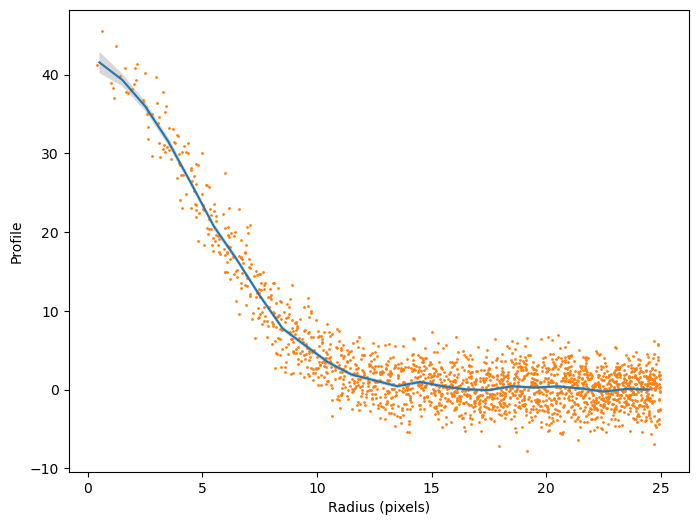

In [77]:
# plot the radial profile
fig, ax = plt.subplots(figsize=(8, 6))
rp.plot(ax=ax, color='C0')
rp.plot_error(ax=ax)
ax.scatter(rp.data_radius, rp.data_profile, s=1, color='C1')
plt.show()

## using 

xypeak: [22.12409373 28.92987985]
[3.14760512]


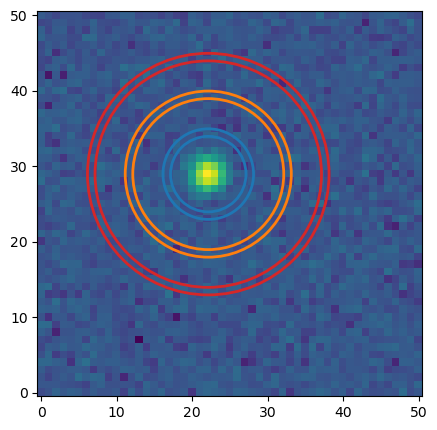

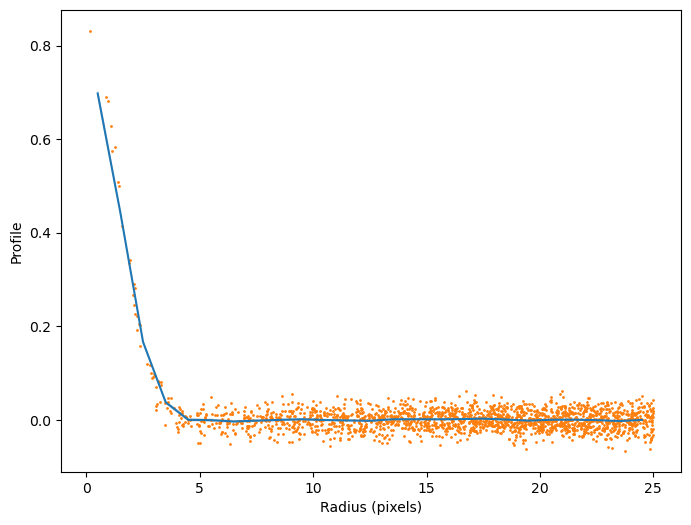

In [145]:
import numpy as np
from photutils.psf import CircularGaussianPRF, fit_fwhm
yy, xx = np.mgrid[:51, :51]
model = CircularGaussianPRF(x_0=22.17, y_0=28.87, fwhm=3.123, flux=9.7)
data = model(xx, yy)
bkg_sig = 0.02
noise = make_noise_image(data.shape, mean=0., stddev=bkg_sig, seed=123)
data += noise

xycen = centroid_quadratic(data)# xpeak=48, ypeak=52)
print(f"xypeak: {xycen}")
error = np.zeros_like(data) + bkg_sig

# create the radial profile
edge_radii = np.arange(26)
rp = RadialProfile(data, xycen, edge_radii, error=error, mask=None)

norm = simple_norm(data, 'sqrt')
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(data, norm=norm, origin='lower')
rp.apertures[5].plot(ax=ax, color='C0', lw=2)
rp.apertures[10].plot(ax=ax, color='C1', lw=2)
rp.apertures[15].plot(ax=ax, color='C3', lw=2)

# plot the radial profile
fig, ax = plt.subplots(figsize=(8, 6))
rp.plot(ax=ax, color='C0')
rp.plot_error(ax=ax)
ax.scatter(rp.data_radius, rp.data_profile, s=1, color='C1')

# Find the fwhm
fwhm = fit_fwhm(data)
print(fwhm)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5]


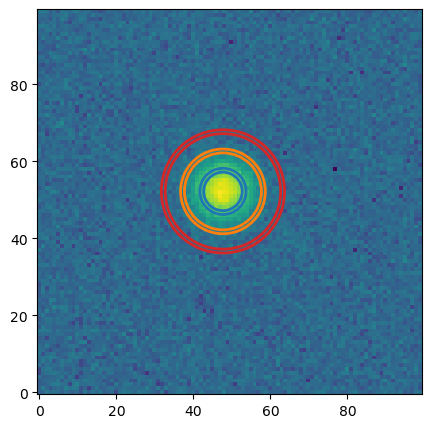

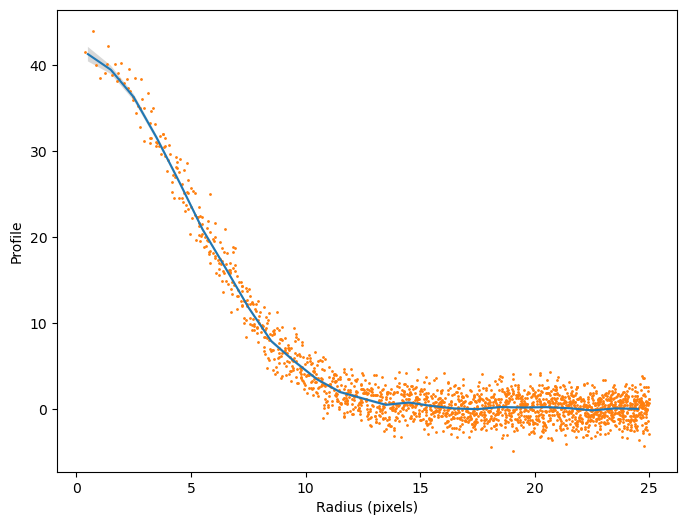

fwhm is [21.07208835]


In [149]:
import numpy as np
from astropy.modeling.models import Gaussian2D
from photutils.centroids import centroid_quadratic
from photutils.datasets import make_noise_image
from photutils.profiles import RadialProfile

gmodel = Gaussian2D(42.1, 47.8, 52.4, 4.7, 4.7, 0)
yy, xx = np.mgrid[0:100, 0:100]
data = gmodel(xx, yy)
bkg_sig = 1.5
noise = make_noise_image(data.shape, mean=0., stddev=bkg_sig, seed=123)
data += noise
error = np.zeros_like(data) + bkg_sig

xycen = centroid_quadratic(data, xpeak=48, ypeak=52)
edge_radii = np.arange(26)
rp = RadialProfile(data, xycen, edge_radii, error=error, mask=None)

print(rp.radius)

norm = simple_norm(data, 'sqrt')
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(data, norm=norm, origin='lower')
rp.apertures[5].plot(ax=ax, color='C0', lw=2)
rp.apertures[10].plot(ax=ax, color='C1', lw=2)
rp.apertures[15].plot(ax=ax, color='C3', lw=2)
plt.show()

# plot the radial profile
fig, ax = plt.subplots(figsize=(8, 6))
rp.plot(ax=ax, color='C0')
rp.plot_error(ax=ax)
ax.scatter(rp.data_radius, rp.data_profile, s=1, color='C1')
plt.show()

# Find the fwhm
fwhm = fit_fwhm(data, fit_shape=3)
print(f"fwhm is {fwhm}")

## Background Subtraction

# `load_star_image`

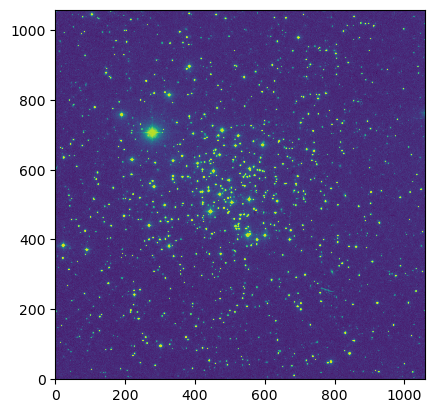

Number of stars found: 2262


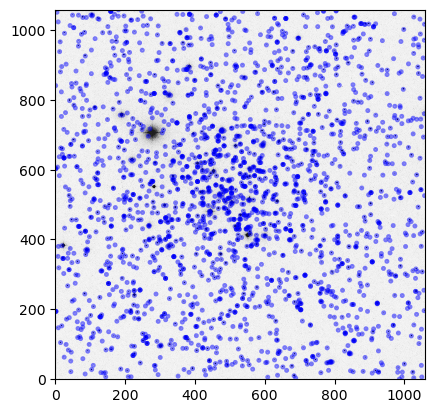

In [21]:
hdu = load_star_image(True)
plt.imshow(hdu.data, origin='lower', interpolation='nearest')
plt.show()
find_stars(hdu.data, fwhm=3.0)

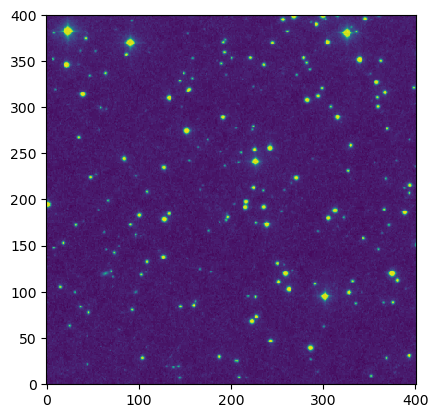

Number of stars found: 315


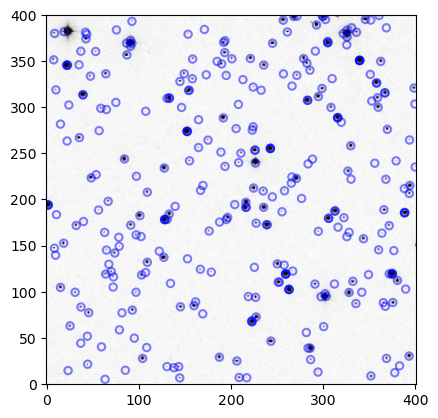

In [34]:
plt.imshow(hdu.data[0:401, 0:401], origin='lower', interpolation='nearest')
plt.show()
find_stars(hdu.data[0:401, 0:401], fwhm=4, std_multiple=4)

# `make_model_image`